In [1]:
import numpy as np
import pandas as pd
import collections
from collections import OrderedDict
import pytorch_lightning as L
import os
import re
import json
import tqdm

from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics.functional import mean_squared_error, mean_absolute_error

from pymatgen.core.composition import Composition
from crabnet.kingcrab import CrabNet

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR, CosineAnnealingLR, StepLR
from torch.nn import L1Loss

from crabnet.utils.utils import (Lamb, Lookahead, RobustL1, BCEWithLogitsLoss,
                         EDMDataset, get_edm, Scaler, DummyScaler, count_parameters)
from crabnet.utils.get_compute_device import get_compute_device
# from crabnet.utils.composition import _element_composition, get_sym_dict, parse_formula, CompositionError
#from utils.optim import SWA

data_type_np = np.float32
data_type_torch = torch.float32

import wandb


class CrabNetDataModule(L.LightningDataModule):
    def __init__(self, train_file: str , 
                 val_file: str, 
                 test_file: str,
                 n_elements ='infer', 
                 classification = False,
                 elem_prop='mat2vec',
                 batch_size = 2**10,
                 scale = True,
                 pin_memory = True):
        super().__init__()
        self.train_path = train_file
        self.val_path = val_file
        self.test_path = test_file
        self.batch_size = batch_size
        self.n_elements=n_elements
        self.pin_memory = pin_memory
        self.scale = scale
        self.classification = classification
        self.elem_prop=elem_prop

    def prepare_data(self):
        ### loading and encoding trianing data
        if(re.search('.json', self.train_path )):
            self.data_train=pd.read_json(self.train_path)
        elif(re.search('.csv', self.train_path)):
            self.data_train=pd.read_csv(self.train_path)

        self.train_main_data = list(get_edm(self.data_train, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=False,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.train_len_data = len(self.train_main_data[0])
        self.train_n_elements = self.train_main_data[0].shape[1]//2

        print(f'loading data with up to {self.train_n_elements:0.0f} '
              f'elements in the formula for training')
        
        ### loading and encoding validation data
        if(re.search('.json', self.val_path )):
            self.data_val=pd.read_json(self.val_path)
        elif(re.search('.csv', self.val_path)):
            self.data_val=pd.read_csv(self.val_path)
        
        self.val_main_data = list(get_edm(self.data_val, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=True,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.val_len_data = len(self.val_main_data[0])
        self.val_n_elements = self.val_main_data[0].shape[1]//2

        print(f'loading data with up to {self.val_n_elements:0.0f} '
              f'elements in the formula for validation')
        
        ### loading and encoding testing data
        if(re.search('.json', self.test_path )):
            self.data_test=pd.read_json(self.test_path)
        elif(re.search('.csv', self.test_path)):
            self.data_test=pd.read_csv(self.test_path)
        
        self.test_main_data = list(get_edm(self.data_test, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=True,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.test_len_data = len(self.test_main_data[0])
        self.test_n_elements = self.test_main_data[0].shape[1]//2

        print(f'loading data with up to {self.test_n_elements:0.0f} '
              f'elements in the formula for testing')

        self.train_dataset = EDMDataset(self.train_main_data, self.train_n_elements)
        self.val_dataset = EDMDataset(self.val_main_data, self.val_n_elements)
        self.test_dataset = EDMDataset(self.test_main_data, self.test_n_elements)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          pin_memory=self.pin_memory, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                        pin_memory=self.pin_memory, shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len_data,
                        pin_memory=self.pin_memory, shuffle=False)
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len_data,
                        pin_memory=self.pin_memory, shuffle=False)


class CrabNetLightning(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = CrabNet(out_dims=config['out_dims'],
                             d_model=config['d_model'],
                             N=config['N'],
                             heads=config['heads'])
        print('\nModel architecture: out_dims, d_model, N, heads')
        print(f'{self.model.out_dims}, {self.model.d_model}, '
                  f'{self.model.N}, {self.model.heads}')
        print(f'Model size: {count_parameters(self.model)} parameters\n')

        ### here we define some important parameters
        self.fudge=config['fudge']
        self.batch_size=config['batch_size']
        self.classification = config['classification']
        self.base_lr=config['base_lr']
        self.max_lr=config['max_lr']
        ### here we also need to initialise scaler based on training data
        if(re.search('.json', config['train_path'] )):
            train_data=pd.read_json(config['train_path'])
        elif(re.search('.csv', config['train_path'])):
            train_data=pd.read_csv(config['train_path'])
        
        y=train_data['target'].values
        self.step_size = len(y)
        if self.classification:
            self.scaler = DummyScaler(y)
        else:
            self.scaler = Scaler(y)

        ### we also define loss function based on task
        if self.classification:
            if(np.sum(y)>0):
                self.weight=torch.tensor(((len(y)-np.sum(y))/np.sum(y))).cuda()
            print("Using BCE loss for classification task")
            self.criterion = BCEWithLogitsLoss
        else:
            print("Using RobustL1 loss for regression task")
            self.criterion = RobustL1
#             self.criterion = L1Loss()

    def forward(self, src, frac):
        out=self.model(src, frac)
        return out

    def configure_optimizers(self):
        base_optim = Lamb(params=self.model.parameters(),lr=0.001)
        optimizer = Lookahead(base_optimizer=base_optim)
        lr_scheduler = CyclicLR(optimizer,
                                base_lr=self.base_lr,
                                max_lr=self.max_lr,
                                cycle_momentum=False,
                                step_size_up=self.step_size)
        # lr_scheduler=StepLR(optimizer,
        #                     step_size=3,
        #                     gamma=0.5)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        prediction=prediction.view(-1)
        uncertainty=uncertainty.view(-1)
        loss = self.criterion(prediction.view(-1),
                              uncertainty.view(-1),
                              y.view(-1))
#         loss=self.criterion(prediction.view(-1),
#                               y.view(-1))
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        y=self.scaler.unscale(y)
        if self.classification:
            prediction = torch.sigmoid(prediction)
            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(y.detach(),prediction.detach())
            mae = mean_absolute_error(y.detach(),prediction.detach())
            self.log("train_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        prediction=prediction.view(-1)
        uncertainty=uncertainty.view(-1)
        val_loss = self.criterion(prediction.view(-1),
                              uncertainty.view(-1),
                              y.view(-1))
#         val_loss=self.criterion(prediction.view(-1),
#                               y.view(-1))
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        y=self.scaler.unscale(y)
        if self.classification:
            prediction = torch.sigmoid(prediction)
            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            
            self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = float(mean_squared_error(y.detach(),prediction.detach()))
            mae = float(mean_absolute_error(y.detach(),prediction.detach()))
            self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return val_loss
     
    def test_step(self, batch, batch_idx):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        prediction=prediction.view(-1)
        uncertainty=uncertainty.view(-1)
        
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        y=self.scaler.unscale(y)
        if self.classification:
            prediction = torch.sigmoid(prediction)
            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            
            self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = float(mean_squared_error(y.detach(),prediction.detach()))
            mae = float(mean_absolute_error(y.detach(),prediction.detach()))
            self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        y=self.scaler.unscale(y)
        if self.classification:
            prediction = torch.sigmoid(prediction)

            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            self.log("predict_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("predict_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("predict_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            
            return formula, y_pred, prediction, uncertainty
        else:
#             mse = float(mean_squared_error(y.detach(),prediction.detach()))
#             mae = float(mean_absolute_error(y.detach(),prediction.detach()))
#             self.log("test_mse", mse, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
#             self.log("test_mae", mae, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        
            return formula, prediction, uncertainty




In [2]:
with open('crabnet/crabnet_config_den.json','r') as f:
        config=json.load(f)

L.seed_everything(config['random_seed'])

Seed set to 29


29

In [3]:
disorder_data = CrabNetDataModule(config['train_path'],
                                   config['val_path'],
                                   config['test_path'],
                                   classification = config['classification'])

In [4]:
data_train=pd.read_csv(disorder_data.train_path)

In [5]:
from crabnet.utils.utils import _element_composition

counts=[]
for i,form in enumerate(data_train['formula']):
    try:
        counts.append(len(_element_composition(form)))
    except:
        print(i,form)

In [6]:
# data_train=data_train.drop(index=34630)
# data_train.reset_index(inplace=True,drop=True)
# data_train.to_csv(disorder_data.train_path)

In [6]:
data_val=pd.read_csv(disorder_data.val_path)
counts=[]
for i,form in enumerate(data_val['formula']):
    try:
        counts.append(len(_element_composition(form)))
    except:
        print(i,form)

In [8]:
data_test=pd.read_csv(disorder_data.test_path)
counts=[]
for i,form in enumerate(data_test['formula']):
    try:
        counts.append(len(_element_composition(form)))
    except:
        print(i,form)

In [3]:
wandb.login(key='b11d318e434d456c201ef1d3c86a3c1ce31b98d7')
wandb.init(project="Crabnet-density")
wandb_logger = WandbLogger(project="Crabnet-density", config=config, log_model="all")
# run.log(config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: epat. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/elena.patyukova/.netrc


In [4]:
model = CrabNetLightning(**config)
trainer = Trainer(max_epochs=100,accelerator='gpu', devices=1, 
                      callbacks=[StochasticWeightAveraging(swa_epoch_start=config['swa_epoch_start'],swa_lrs=config['swa_lrs']),
                                EarlyStopping(monitor='val_mae', patience=config['patience']), ModelCheckpoint(monitor='val_mae', mode="min", 
                                dirpath='crabnet_models/crabnet_trained_models/', filename='density-{epoch:02d}-{val_acc:.2f}')])
disorder_data = CrabNetDataModule(config['train_path'],
                                   config['val_path'],
                                   config['test_path'],
                                   classification = config['classification'])
disorder_data.prepare_data()
trainer.fit(model, datamodule=disorder_data)
trainer.test(ckpt_path='best',datamodule=disorder_data)

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using RobustL1 loss for regression task


Generating EDM: 100%|████████████████████████████████████████████| 74818/74818 [00:00<00:00, 313841.76formulae/s]


loading data with up to 9 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 8314/8314 [00:00<00:00, 305538.75formulae/s]

loading data with up to 7 elements in the formula for validation



Generating EDM: 100%|████████████████████████████████████████████| 20784/20784 [00:00<00:00, 318787.72formulae/s]


loading data with up to 8 elements in the formula for testing


Generating EDM: 100%|████████████████████████████████████████████| 74818/74818 [00:00<00:00, 318445.04formulae/s]


loading data with up to 9 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 8314/8314 [00:00<00:00, 349988.39formulae/s]

loading data with up to 7 elements in the formula for validation



Generating EDM: 100%|████████████████████████████████████████████| 20784/20784 [00:00<00:00, 317133.95formulae/s]


loading data with up to 8 elements in the formula for testing


/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models exists and is not empty.

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | CrabNet | 12.0 M | train
------------------------------------------
12.0 M    Trainable params
23.8 K    Non-trainable params
12.0 M    Total params
48.044    Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                         | 0/? [00:00<?, ?it…

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Swapping scheduler `CyclicLR` for `SWALR`


Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Generating EDM: 100%|████████████████████████████████████████████| 74818/74818 [00:00<00:00, 301708.51formulae/s]


loading data with up to 9 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 8314/8314 [00:00<00:00, 287253.64formulae/s]

loading data with up to 7 elements in the formula for validation



Generating EDM: 100%|████████████████████████████████████████████| 20784/20784 [00:00<00:00, 274764.99formulae/s]
Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt
Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt


loading data with up to 8 elements in the formula for testing


/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                 | 0/? [00:00<?, ?it…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_mae          │    0.3257540464401245     │
│          val_mse          │    1.0541478395462036     │
└───────────────────────────┴───────────────────────────┘

[{'val_mse': 1.0541478395462036, 'val_mae': 0.3257540464401245}]

In [5]:
for x in disorder_data.test_dataloader():
    X, y_true, formula = x

In [7]:
trainer.test(ckpt_path='best', datamodule=disorder_data)

Generating EDM: 100%|████████████████████████████████████████████| 74818/74818 [00:00<00:00, 220148.71formulae/s]


loading data with up to 9 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 8314/8314 [00:00<00:00, 332428.75formulae/s]

loading data with up to 7 elements in the formula for validation



Generating EDM: 100%|████████████████████████████████████████████| 20784/20784 [00:00<00:00, 290893.61formulae/s]
Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt


loading data with up to 8 elements in the formula for testing


Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                 | 0/? [00:00<?, ?it…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_mae          │    0.32553887367248535    │
│          val_mse          │    1.0438387393951416     │
└───────────────────────────┴───────────────────────────┘

[{'val_mse': 1.0438387393951416, 'val_mae': 0.32553887367248535}]

In [8]:
formula, prediction, uncertainty=trainer.predict(model=model,ckpt_path='best', datamodule=disorder_data)[0]

Generating EDM: 100%|████████████████████████████████████████████| 74818/74818 [00:00<00:00, 262548.87formulae/s]


loading data with up to 9 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 8314/8314 [00:00<00:00, 336110.30formulae/s]

loading data with up to 7 elements in the formula for validation



Generating EDM: 100%|████████████████████████████████████████████| 20784/20784 [00:00<00:00, 303230.12formulae/s]
Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt


loading data with up to 8 elements in the formula for testing


Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                              | 0/? [00:00<?, ?it…

In [9]:
y_pred = prediction.view(-1).detach().cpu().numpy() 

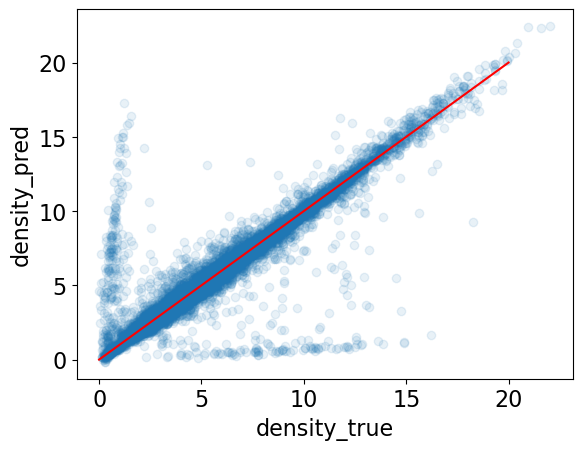

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_true,y_pred,alpha=0.1)
# plt.plot([0,100],[0,100],color='red')
plt.plot([0,20],[0,20],color='red')
plt.xlabel('density_true')
plt.ylabel('density_pred')
plt.show()

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_score(y_true,y_pred),mean_absolute_error(y_true,y_pred),mean_squared_error(y_true,y_pred)

(0.8751957416534424, 0.32587248, 1.0459156)

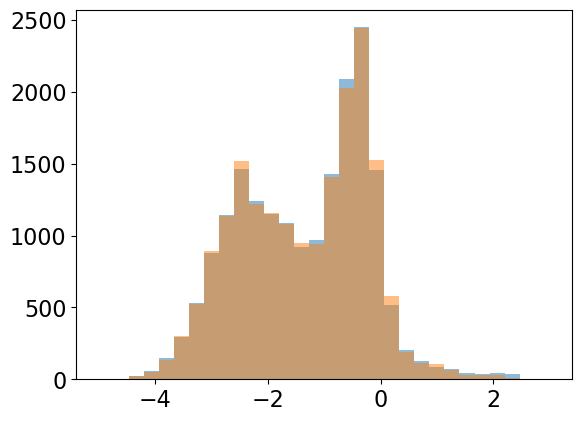

In [19]:
plt.hist(y_true,bins=30,alpha=0.5,range=(-5,3))
plt.hist(y_pred,bins=30,alpha=0.5,range=(-5,3))
plt.show()

In [3]:
with open('crabnet/crabnet_config.json','r') as f:
        config=json.load(f)

L.seed_everything(config['random_seed'])

Seed set to 29


29

In [4]:
config

{'train_path': 'data/composition/train.csv',
 'val_path': 'data/composition/val.csv',
 'test_path': 'data/composition/test.csv',
 'out_dims': 3,
 'd_model': 512,
 'out_hidden': [1024, 512, 256, 128],
 'N': 3,
 'heads': 4,
 'classification': False,
 'batch_size': 256,
 'fudge': 0.02,
 'random_seed': 29,
 'swa_epoch_start': 0.05,
 'swa_lrs': 0.01,
 'base_lr': 0.005,
 'max_lr': 0.01,
 'schedule': 'CyclicLR',
 'patience': 20,
 'num_workers': 1}

In [5]:
model = CrabNetLightning.load_from_checkpoint('crabnet_models/crabnet_trained_models/density-epoch=59-val_acc=0.00.ckpt',**config)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using RobustL1 loss for regression task


/opt/miniconda3/envs/llm/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
for name, param in model.named_parameters():
    if "output_nn" not in name:  # Replace 'fc' with the target layer of your model
        param.requires_grad = False

In [7]:
print('hyperparameters:', model.hparams)

hyperparameters: "N":               3
"base_lr":         0.005
"batch_size":      256
"classification":  False
"d_model":         512
"fudge":           0.02
"heads":           4
"max_lr":          0.01
"num_workers":     1
"out_dims":        3
"out_hidden":      [1024, 512, 256, 128]
"patience":        20
"random_seed":     29
"schedule":        CyclicLR
"swa_epoch_start": 0.05
"swa_lrs":         0.01
"test_path":       data/composition/test.csv
"train_path":      data/composition/train.csv
"val_path":        data/composition/val.csv


In [8]:
trainer = Trainer(max_epochs=100,accelerator='gpu', devices=1, 
                      callbacks=[StochasticWeightAveraging(swa_epoch_start=config['swa_epoch_start'],swa_lrs=config['swa_lrs']),
                                EarlyStopping(monitor='val_mae', patience=config['patience']), ModelCheckpoint(monitor='val_mae', mode="min", 
                                dirpath='crabnet_models/crabnet_trained_models/', filename='trans-den-kspace-{epoch:02d}-{val_acc:.2f}')])
disorder_data = CrabNetDataModule(config['train_path'],
                                   config['val_path'],
                                   config['test_path'],
                                   classification = config['classification'])
disorder_data.prepare_data()
trainer.fit(model, datamodule=disorder_data)
trainer.test(ckpt_path='best',datamodule=disorder_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Generating EDM: 100%|████████████████████████████████████████████| 37209/37209 [00:00<00:00, 316775.65formulae/s]


loading data with up to 7 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 4136/4136 [00:00<00:00, 346426.26formulae/s]


loading data with up to 6 elements in the formula for validation


Generating EDM: 100%|████████████████████████████████████████████| 10340/10340 [00:00<00:00, 346155.29formulae/s]


loading data with up to 6 elements in the formula for testing


Generating EDM: 100%|████████████████████████████████████████████| 37209/37209 [00:00<00:00, 340199.54formulae/s]


loading data with up to 7 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 4136/4136 [00:00<00:00, 372314.92formulae/s]


loading data with up to 6 elements in the formula for validation


Generating EDM: 100%|████████████████████████████████████████████| 10340/10340 [00:00<00:00, 373810.35formulae/s]


loading data with up to 6 elements in the formula for testing


/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models exists and is not empty.

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | CrabNet | 12.0 M | train
------------------------------------------
2.4 M     Trainable params
9.6 M     Non-trainable params
12.0 M    Total params
48.044    Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                         | 0/? [00:00<?, ?it…

/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Swapping scheduler `CyclicLR` for `SWALR`


Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Validation: |                                                                              | 0/? [00:00<?, ?it…

Generating EDM: 100%|████████████████████████████████████████████| 37209/37209 [00:00<00:00, 318158.92formulae/s]


loading data with up to 7 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 4136/4136 [00:00<00:00, 317710.73formulae/s]


loading data with up to 6 elements in the formula for validation


Generating EDM: 100%|████████████████████████████████████████████| 10340/10340 [00:00<00:00, 360280.32formulae/s]
Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/trans-den-kspace-epoch=47-val_acc=0.00.ckpt


loading data with up to 6 elements in the formula for testing


Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/trans-den-kspace-epoch=47-val_acc=0.00.ckpt
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                 | 0/? [00:00<?, ?it…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_mae          │    10.669547080993652     │
│          val_mse          │     225.0922088623047     │
└───────────────────────────┴───────────────────────────┘

[{'val_mse': 225.0922088623047, 'val_mae': 10.669547080993652}]

In [9]:
for x in disorder_data.predict_dataloader():
    X, y_true, formula = x

In [11]:
formula, prediction, uncertainty=trainer.predict(ckpt_path='best', datamodule=disorder_data)[0]

Generating EDM: 100%|████████████████████████████████████████████| 37209/37209 [00:00<00:00, 334469.60formulae/s]


loading data with up to 7 elements in the formula for training


Generating EDM: 100%|██████████████████████████████████████████████| 4136/4136 [00:00<00:00, 346336.35formulae/s]


loading data with up to 6 elements in the formula for validation


Generating EDM: 100%|████████████████████████████████████████████| 10340/10340 [00:00<00:00, 344423.38formulae/s]
Restoring states from the checkpoint path at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/trans-den-kspace-epoch=47-val_acc=0.00.ckpt


loading data with up to 6 elements in the formula for testing


Loaded model weights from the checkpoint at /Users/elena.patyukova/Documents/github/ML_for_Me_prediction/Kspacing/crabnet_models/crabnet_trained_models/trans-den-kspace-epoch=47-val_acc=0.00.ckpt
/opt/miniconda3/envs/llm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                              | 0/? [00:00<?, ?it…

In [12]:
y_pred = prediction.view(-1).detach().cpu().numpy() 

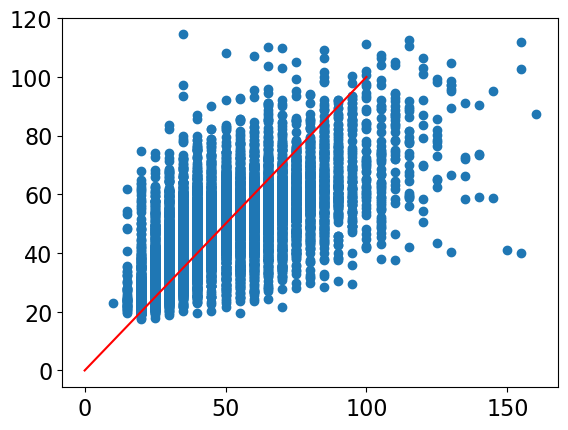

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_true,y_pred)
plt.plot([0,100],[0,100],color='red')
plt.show()

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_score(y_true,y_pred),mean_absolute_error(y_true,y_pred),mean_squared_error(y_true,y_pred)

(0.4949786067008972, 10.659738, 225.01196)